In [3]:
import requests, re, html, csv
from bs4 import BeautifulSoup


In [4]:
# Function to search for a movie by title
def search_movie_by_title(title):
    search_url = f'http://www.boxofficemojo.com/search/?q={title.replace(" ", "+")}'
    response = requests.get(search_url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        # Find the first search result link
        result_link = soup.find('a', {'class': 'a-size-medium a-link-normal a-text-bold'})
        print("results: ", result_link)
        if result_link:
            movie_url = result_link['href']
            return movie_url
        else:
            return None
    else:
        print(f'Failed to retrieve search results. Status Code: {response.status_code}')
        return None

def extract_values_from_html_array(html_array):
    pattern = r'<span class="money">\$([0-9,]+)</span>'
    values = []

    for item in html_array:
        match = re.search(pattern, str(item))
        if match:
            value = match.group(1)
            value = int(value.replace(',', ''))
            values.append(value)
    return values


# Function to scrape box office revenue and budget from a movie's page
def scrape_movie_data(movie_url):
    print("movie url::", 'https://www.boxofficemojo.com' + movie_url)
    response = requests.get('https://www.boxofficemojo.com' + movie_url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')

        revenue_element = soup.find('div', {'class': 'a-section a-spacing-none mojo-performance-summary-table'})
        budget_element = soup.find('div', {'class': 'a-section a-spacing-none mojo-summary-values mojo-hidden-from-mobile'})


        if revenue_element and budget_element:
            revenue = revenue_element.find_all('span', {'class': 'money'})
            budget = budget_element.find_all('span', {'class': 'money'})

            return revenue, budget
        else:
            return None, None
    else:
        print(f'Failed to retrieve data. Status Code: {response.status_code}')
        return None, None


def revenue_budget(title):
  print("Title: ", title)
  movie_url = search_movie_by_title(title)
  print(movie_url)
  if movie_url:
      revenue, budget = scrape_movie_data( movie_url)

      if revenue:
          data = extract_values_from_html_array(revenue)
          if len(data) == 2:
            domestic, international, worldwide = data[0], 0, data[1]
          else:
            domestic, international, worldwide = data

          if budget:
            budget = extract_values_from_html_array(budget)
            budget = 0 if len(budget) == 1 else budget[-1]
            print("Data: ", data)
          else:
            budget = 0

          return domestic, international, worldwide, budget
      else:
          print('Data not found.')
          return 0,0,0,0
  else:
      print('Movie not found in Box Office Mojo.')
      return 0,0,0,0




In [ ]:
import csv
from tqdm import tqdm  # Import the tqdm library

def append_movie_data_to_csv(input_file, output_file):
    with open(input_file, 'r') as csv_input, open(output_file, 'w', newline='') as csv_output:
        reader = csv.reader(csv_input)
        writer = csv.writer(csv_output)

        header = next(reader)
        header.extend(["domestic_revenue", "international_revenue", "worldwide_revenue", "budget"])
        writer.writerow(header)

        # Wrap your loop with tqdm for the progress bar
        for row in tqdm(reader, desc="Processing rows"):
            movie_name = row[1]  # Assuming movie name is in the second column
            domestic_revenue, international_revenue, worldwide_revenue, budget = revenue_budget(movie_name)
            print("csv data: ", domestic_revenue, international_revenue, worldwide_revenue, budget)
            row.extend([domestic_revenue, international_revenue, worldwide_revenue, budget])
            writer.writerow(row)

# Example usage
input_file = 'Data/Final/output_movies_data_0-45k_by_year_2000+.csv'
output_file = 'Data/Final/output_movies_with_budget.csv'

# Call the function
append_movie_data_to_csv(input_file, output_file)

In [12]:
import csv

def calculate_percentage_of_zeros(input_file):
    with open(input_file, 'r') as csv_file:
        reader = csv.DictReader(csv_file)

        # Initialize counters for each column
        counts = {
            "domestic_revenue": {"zero": 0, "non_zero": 0},
            "international_revenue": {"zero": 0, "non_zero": 0},
            "worldwide_revenue": {"zero": 0, "non_zero": 0},
            "budget": {"zero": 0, "non_zero": 0}
        }

        # Count zero and non-zero values for each column
        for row in reader:
            for column in counts:
                value = int(row[column]) if row[column].isdigit() else 0
                if value == 0:
                    counts[column]["zero"] += 1
                else:
                    counts[column]["non_zero"] += 1

        # Calculate percentages
        percentages = {}
        for column, count in counts.items():
            total = count["zero"] + count["non_zero"]
            percentages[column] = {
                "zero_percentage": (count["zero"] / total) * 100,
                "non_zero_percentage": (count["non_zero"] / total) * 100
            }

        return percentages

# Example usage
output_file = 'Data/Final/output_movies_data_25k_hassan.csv'
percentages = calculate_percentage_of_zeros(output_file)
for column, percentage in percentages.items():
    print(f"{column}: Zero - {percentage['zero_percentage']:.2f}%, Non-Zero - {percentage['non_zero_percentage']:.2f}%")



domestic_revenue: Zero - 8.24%, Non-Zero - 91.76%
international_revenue: Zero - 52.94%, Non-Zero - 47.06%
worldwide_revenue: Zero - 8.24%, Non-Zero - 91.76%
budget: Zero - 75.29%, Non-Zero - 24.71%


In [16]:
import csv

def remove_columns_and_zero_rows(input_file, output_file, columns_to_remove, check_zero_columns):
    with open(input_file, 'r') as csv_input, open(output_file, 'w', newline='') as csv_output:
        reader = csv.DictReader(csv_input)
        fieldnames = [field for field in reader.fieldnames if field not in columns_to_remove]

        writer = csv.DictWriter(csv_output, fieldnames=fieldnames)
        writer.writeheader()

        for row in reader:
            # Check if either of the remaining columns has a zero value
            if any(int(row[column]) == 0 for column in check_zero_columns if row[column].isdigit()):
                continue

            # Remove the unwanted columns
            for column in columns_to_remove:
                row.pop(column, None)
            writer.writerow(row)

# Example usage
input_file = 'Data/Final/output_movies_data_0-45k_by_year_2000+.csv'
output_file = 'Data/Final/Cleaned_output_movies_data_all_hassan.csv'
columns_to_remove = ["domestic_revenue", "international_revenue"]
check_zero_columns = ["worldwide_revenue", "budget"]  # Check these columns for zero values

remove_columns_and_zero_rows(input_file, output_file, columns_to_remove, check_zero_columns)


In [124]:
import csv
import math
import pprint
import pandas as pd
import ast  # Import ast module


def shannon_diversity_index(ethnicities):
    import math
    total = sum(ethnicities.values())
    if total == 0:
        return 0
    shannon_index = -sum((count / total) * math.log(count / total) for count in ethnicities.values() if count > 0)
    return shannon_index

def gini_simpson_index(ethnicities):
    total = sum(ethnicities.values())
    if total == 0:
        return 0
    sum_of_squares = sum((count / total) ** 2 for count in ethnicities.values())
    return 1 - sum_of_squares

def load_cast_ethnicity(file_name):
    ethnicity_data = {}
    with open(file_name, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            name = row['Name']
            actor_ethnicities = {ethnicity: float(row[ethnicity]) for ethnicity in row if ethnicity != 'Name' and ethnicity != '2PRACE'}
            ethnicity_data[name] = actor_ethnicities
    return ethnicity_data

def get_average_diversity_score(actor_names, ethnicity_data, missing_actors, diversity_func):
    scores = []
    for name in actor_names:
        name = name.strip()
        if name in ethnicity_data:
            scores.append(diversity_func(ethnicity_data[name]))
        else:
            missing_actors.add(name)
    return sum(scores) / len(scores) if scores else 0

def append_diversity_scores_to_movies(movies_file, ethnicity_data, output_file):
    df = pd.read_csv(movies_file)
    missing_actors = set()

    # Calculate and append each type of diversity score
    diversity_functions = [shannon_diversity_index,  gini_simpson_index]
    for func in diversity_functions:
        column_name = f"diversity_score_{func.__name__}"
        df[column_name] = df['actors'].apply(lambda actors: 
            get_average_diversity_score(parse_actors(actors), ethnicity_data, missing_actors, func) 
            if pd.notna(actors) else 0
        )

    df.to_csv(output_file, index=False)
    return missing_actors



# Load cast ethnicity data
cast_ethnicity_data = load_cast_ethnicity('Data/Final/Ethnicity/cast_ethnicity.csv')

# Append diversity scores to each movie and get missing actors
missing_actors = append_diversity_scores_to_movies('Merged_diversity_movies.csv', cast_ethnicity_data, 'data_with_diversity.csv')
print(f"Actors not found in ethnicity data: {missing_actors}")












Actors not found in ethnicity data: set()


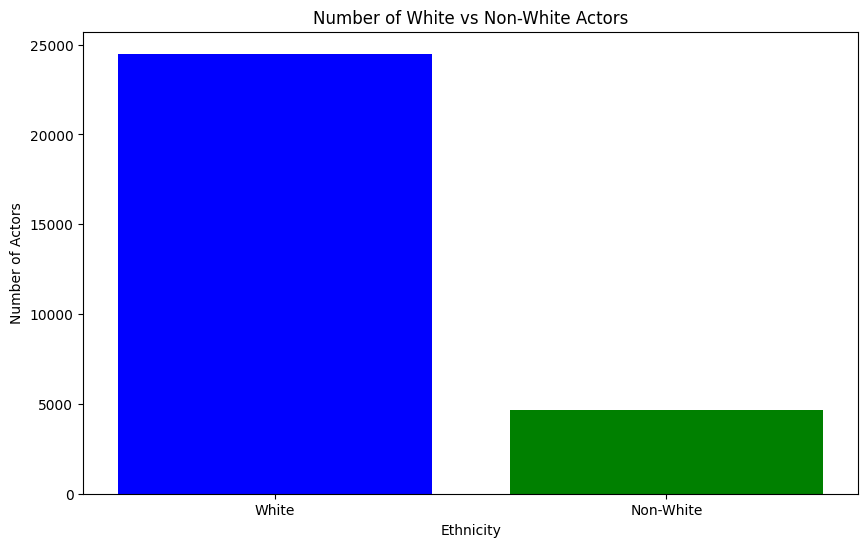

In [146]:
import matplotlib.pyplot as plt
import pandas as pd

def aggregate_ethnicity_data(ethnicity_data):
    white_count = 0
    non_white_count = 0
    for actor, ethnicities in ethnicity_data.items():
        white_count += ethnicities.get('White', 0)
        non_white_count += sum(count for eth, count in ethnicities.items() if eth != 'White')
    return white_count, non_white_count

# Load cast ethnicity data
cast_ethnicity_data = load_cast_ethnicity('Data/Final/Ethnicity/cast_ethnicity.csv')

# Aggregate the data
white_count, non_white_count = aggregate_ethnicity_data(cast_ethnicity_data)

# Prepare data for visualization
data = {'Ethnicity': ['White', 'Non-White'], 'Count': [white_count, non_white_count]}
df = pd.DataFrame(data)

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(df['Ethnicity'], df['Count'], color=['blue', 'green'])
plt.xlabel('Ethnicity')
plt.ylabel('Number of Actors')
plt.title('Number of White vs Non-White Actors')
plt.show()


/var/folders/b_/lxxyjnjs19lgxdfkyr1t4ntm0000gn/T/ipykernel_56308/3506838774.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[index_name], kde=False, bins=20)


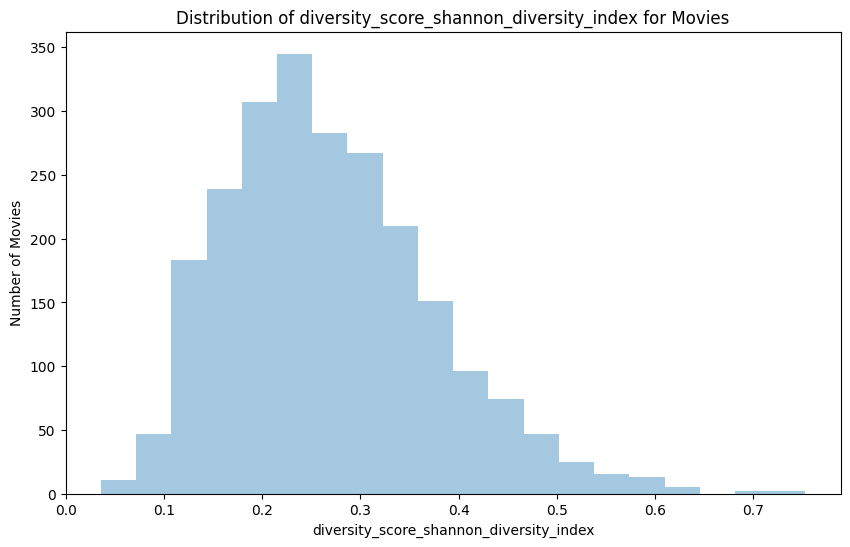

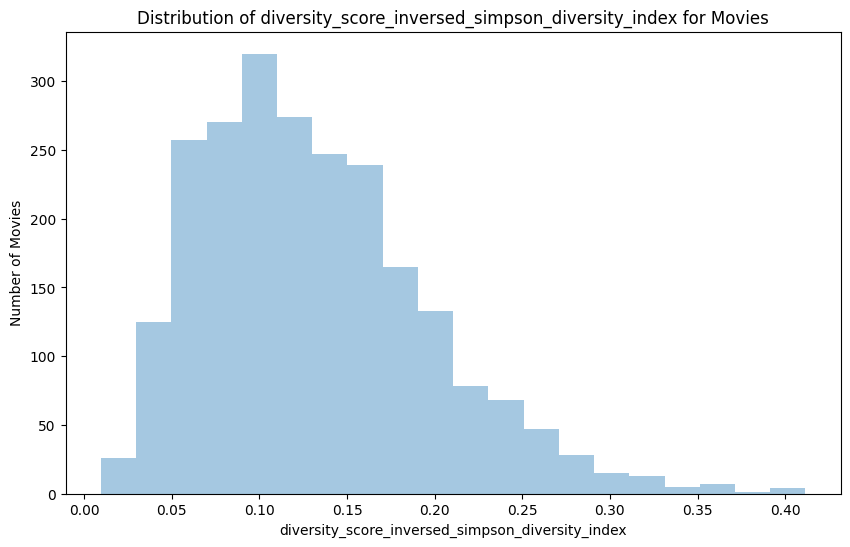

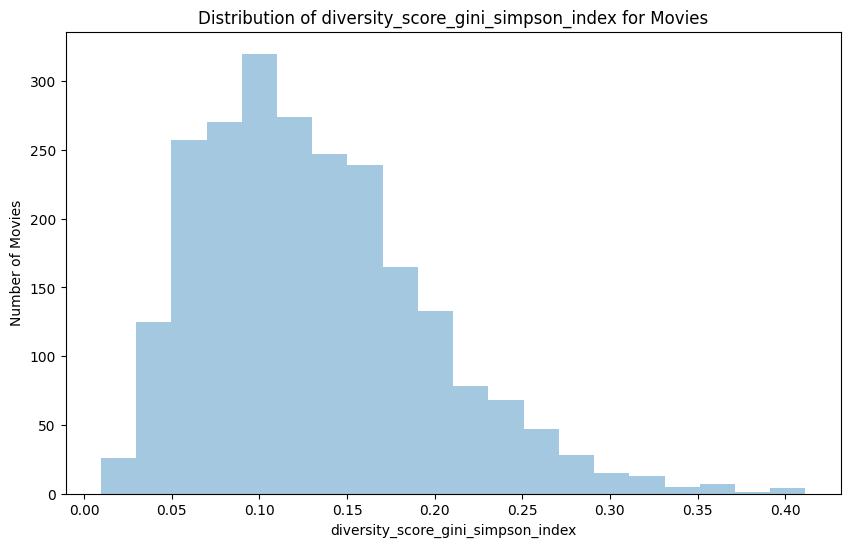

In [128]:
#make distribution graphs for each of the diversity indices
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import math
import ast


#plot the different diversithy indices
def plot_diversity_index(df, index_name):
    plt.figure(figsize=(10, 6))
    sns.distplot(df[index_name], kde=False, bins=20)
    plt.title(f"Distribution of {index_name} for Movies")
    plt.xlabel(f"{index_name}")
    plt.ylabel("Number of Movies")
    plt.show()
    #calculate and return the mean value of a given column in dataframe df
    return df[index_name].mean()
#function to calculate the mean values of all columns in dataframe df
def calculate_mean_values(df):
    mean_values = {}
    for column in df.columns:
        mean_values[column] = df[column].mean()
    return mean_values
#load data from csv file into dataframe df
df = pd.read_csv('data_with_diversity.csv')
#plot the different diversity indices
shannon_diversity_mean = plot_diversity_index(df, 'diversity_score_shannon_diversity_index')
inversed_simpson_diversity_mean = plot_diversity_index(df, 'diversity_score_inversed_simpson_diversity_index')
gini_simpson_diversity_mean = plot_diversity_index(df, 'diversity_score_gini_simpson_index')
#calculate the mean values of all columns in dataframe df
#drop diverity score weighted
df = df.drop(columns=['diversity_score'])



In [99]:

def load_cast_ethnicity(file_name):
    ethnicity_data = {}
    with open(file_name, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            name = row['Name']
            # Directly use the ethnicities' probabilities
            actor_ethnicities = {ethnicity: float(row[ethnicity]) for ethnicity in row if ethnicity != 'Name' and ethnicity != '2PRACE'}
            ethnicity_data[name] = actor_ethnicities
    return ethnicity_data

# ... [rest of your existing script] ...

def calculate_proportion_of_ethnic_groups(ethnicity_data):
    # Initialize a dictionary to hold the sum of probabilities for each ethnicity
    total_ethnicities = {}
    for actor in ethnicity_data:
        for ethnicity, probability in ethnicity_data[actor].items():
            if ethnicity not in total_ethnicities:
                total_ethnicities[ethnicity] = 0
            total_ethnicities[ethnicity] += probability

    # Sum the total probabilities to normalize
    total = sum(total_ethnicities.values())

    # Calculate the proportion for each ethnicity
    for ethnicity in total_ethnicities:
        total_ethnicities[ethnicity] /= total

    return total_ethnicities

# Load cast ethnicity data
cast_ethnicity_data = load_cast_ethnicity('Data/Final/Ethnicity/cast_ethnicity.csv')

# Calculate the proportion of each ethnic group
ethnicity_proportions = calculate_proportion_of_ethnic_groups(cast_ethnicity_data)
print("Proportion of each ethnic group:", ethnicity_proportions)

Proportion of each ethnic group: {'Hispanic': 0.05294338641050376, 'API': 0.060492678834054195, 'Black': 0.04517138051788554, 'AIAN': 0.0017177252635889521, 'White': 0.8396748289739676}


In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Load the data
df = pd.read_csv('data_with_diversity.csv')






# #remove the dollar sign from WorldwideGRoss and Production budget
# df['WorldwideGross'] = df['WorldwideGross'].str.replace('$', '')
# df['Production Budget'] = df['Production Budget'].str.replace('$', '')

# #remove the commas from WorldwideGRoss and Production budget
# df['WorldwideGross'] = df['WorldwideGross'].str.replace(',', '')
# df['Production Budget'] = df['Production Budget'].str.replace(',', '')


# #convert the WorldwideGross and Production Budget columns to numeric
# df['WorldwideGross'] = pd.to_numeric(df['WorldwideGross'])
# df['Production Budget'] = pd.to_numeric(df['Production Budget'])



# # Calculate profitability
# df['profitability'] = df['WorldwideGross'] - df['Production Budget']

# #add profitbaility to the file
# df.to_csv('data_with_diversity.csv', index=False)

# # Scatter Plot
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=df, x='diversity_score', y='profitability')
# plt.title('Diversity Score vs Profitability')
# plt.xlabel('Diversity Score')
# plt.ylabel('Profitability')
# plt.show()

# # Histogram - Diversity Score
# plt.figure(figsize=(10, 6))
# sns.histplot(df['diversity_score'], kde=True)
# plt.title('Distribution of Diversity Scores')
# plt.xlabel('Diversity Score')
# plt.ylabel('Frequency')
# plt.show()

# # Histogram - Diversity Score
# plt.figure(figsize=(10, 6))
# sns.histplot(df['diversity_score'], kde=True)
# plt.title('Distribution of Diversity Scores')
# plt.xlabel('Diversity Score')
# plt.ylabel('Frequency')
# plt.show()

# # Histogram - Profitability
# plt.figure(figsize=(10, 6))
# sns.histplot(df['profitability'], kde=True)
# plt.title('Distribution of Profitability')
# plt.xlabel('Profitability')
# plt.ylabel('Frequency')
# plt.show()

# # Correlation
# correlation, p_value = stats.pearsonr(df['diversity_score'], df['profitability'])
# print(f"Correlation Coefficient: {correlation}")
# print(f"P-value: {p_value}")

# # T-test (splitting data into high and low diversity)
# median_diversity = df['diversity_score'].median()
# high_diversity = df[df['diversity_score'] > median_diversity]['profitability']
# low_diversity = df[df['diversity_score'] <= median_diversity]['profitability']

# t_stat, p_val_t_test = stats.ttest_ind(high_diversity, low_diversity, equal_var=False)
# print(f"T-Statistic: {t_stat}")
# print(f"P-value (T-test): {p_val_t_test}")

#chnage profitability to be a percentage of worldwidegross to budget
df['profitability'] = ((df['WorldwideGross']-df['Production Budget'])/df['Production Budget'])*100
#add profitbaility to the file
df.to_csv('data_with_diversity.csv', index=False)


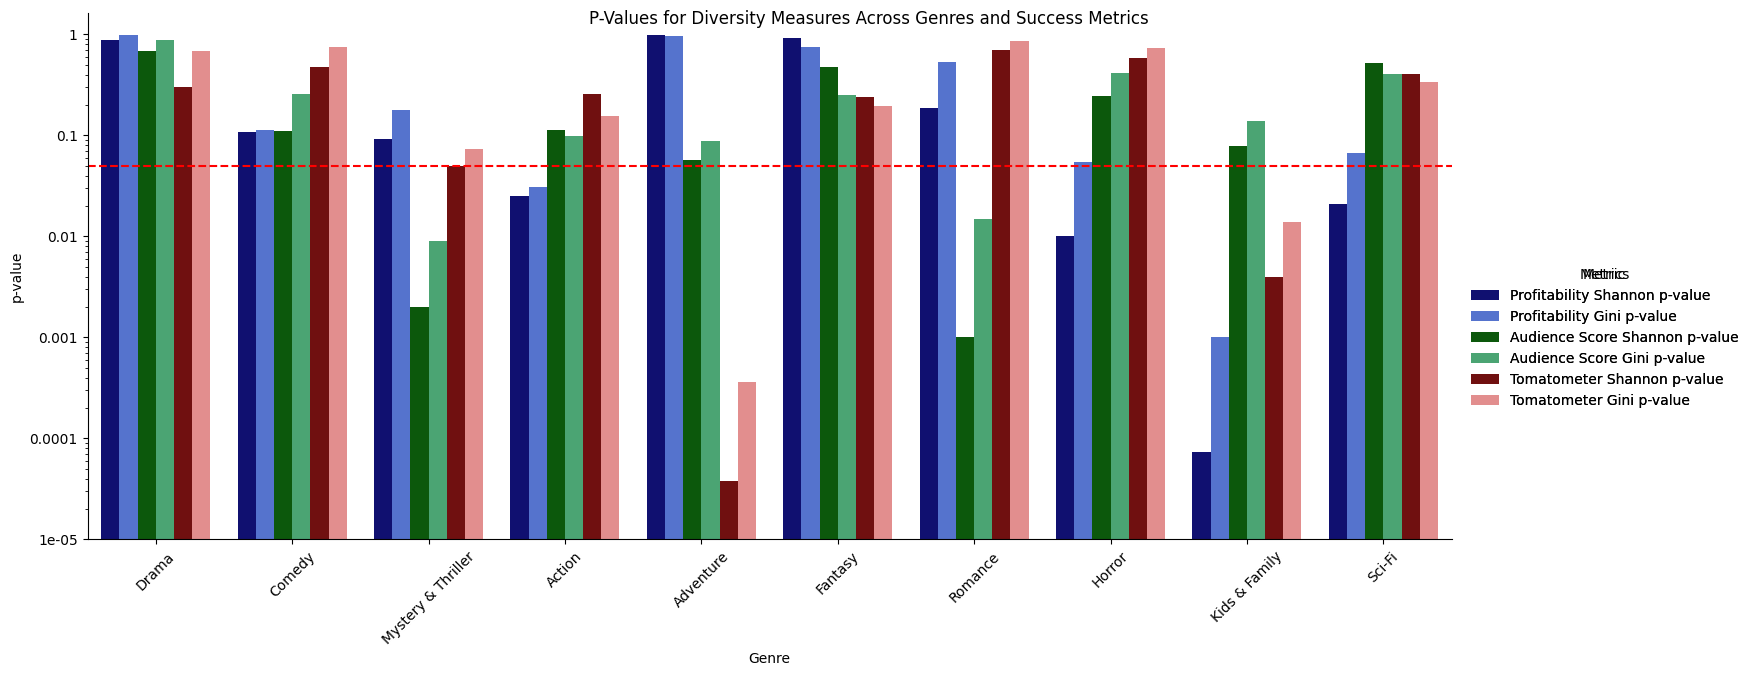

In [145]:

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = {
    "Genre": ["Drama", "Comedy", "Mystery & Thriller", "Action", "Adventure", "Fantasy", "Romance", "Horror", "Kids & Family", "Sci-Fi"],
    "Profitability Shannon p-value": [0.878, 0.108, 0.091, 0.025, 0.988, 0.913, 0.186, 0.010, 0.000074, 0.021],
    "Profitability Gini p-value": [0.983, 0.112, 0.177, 0.031, 0.956, 0.749, 0.531, 0.054, 0.001, 0.067],
    "Audience Score Shannon p-value": [0.678, 0.111, 0.002, 0.112, 0.057, 0.472, 0.001, 0.245, 0.078, 0.517],
    "Audience Score Gini p-value": [0.883, 0.254, 0.009, 0.098, 0.088, 0.252, 0.015, 0.411, 0.140, 0.401],
    "Tomatometer Shannon p-value": [0.302, 0.478, 0.050, 0.259, 0.000038, 0.238, 0.704, 0.579, 0.004, 0.406],
    "Tomatometer Gini p-value": [0.681, 0.748, 0.073, 0.155, 0.000363, 0.197, 0.855, 0.737, 0.014, 0.334]
}

consolidated_df = pd.DataFrame(data)

# Melt the DataFrame to long format for seaborn plotting
long_df = consolidated_df.melt(id_vars='Genre', var_name='Metric', value_name='p-value')

# Add a column to indicate significance
significance_threshold = 0.05
long_df['Significant'] = long_df['p-value'] < significance_threshold

palette = {
    "Profitability Shannon p-value": "navy",
    "Profitability Gini p-value": "royalblue",
    "Audience Score Shannon p-value": "darkgreen",
    "Audience Score Gini p-value": "mediumseagreen",
    "Tomatometer Shannon p-value": "maroon",
    "Tomatometer Gini p-value": "lightcoral"
}

# Create a categorical plot with seaborn
g = sns.catplot(
    data=long_df,
    kind='bar',  # or 'point' for a dot plot
    x='Genre',
    y='p-value',
    hue='Metric',
    aspect=2,
    height=6,
    palette=palette
)

# Adjust the details of the plot
g.set_axis_labels('Genre', 'p-value')
g.add_legend(title='Metrics')
g.fig.suptitle('P-Values for Diversity Measures Across Genres and Success Metrics')
plt.axhline(y=significance_threshold, color='red', linestyle='--')
plt.yscale('log')  # Optional for better visibility of small p-values
ticks = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
plt.yticks(ticks, labels=ticks)
plt.xticks(rotation=45)
plt.show()


In [152]:
!pip install stargazer


MLR Model Summary for TomatoMeter:
                            OLS Regression Results                            
Dep. Variable:            tomatometer   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     21.91
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           5.42e-14
Time:                        21:19:26   Log-Likelihood:                -10965.
No. Observations:                2322   AIC:                         2.194e+04
Df Residuals:                    2318   BIC:                         2.196e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

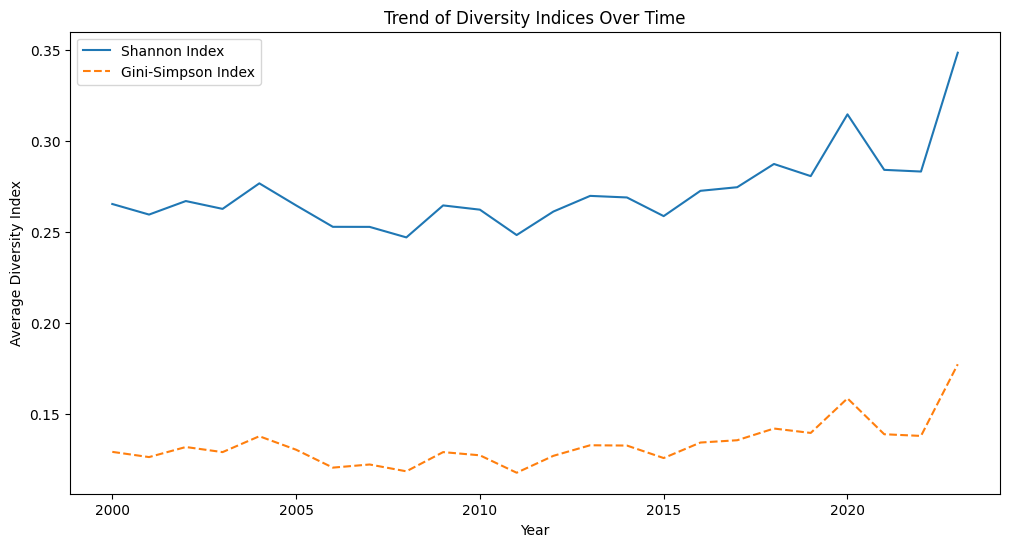

In [161]:
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

# Preparing the data for MLR analysis on the entire dataset
# Using 'diversity_score_shannon_diversity_index' and 'diversity_score_gini_simpson_index' as independent variables
# 'audience_score' and 'tomatometer' as dependent variables in separate models

# Independent Variables
X = data[['diversity_score_shannon_diversity_index', 'year', 'Production Budget']]
X = sm.add_constant(X)  # Adding a constant for intercept

# Dependent Variable 1: Audience Score
y_audience = data['audience_score']
model_audience = sm.OLS(y_audience, X).fit()

# Dependent Variable 2: Tomatometer
y_tomatometer = data['tomatometer']
model_tomatometer = sm.OLS(y_tomatometer, X).fit()

y_profitability = data['profitability']
model_profitability = sm.OLS(y_profitability, X).fit()  


# Summary of the MLR model for Audience Score

print("MLR Model Summary for TomatoMeter:")
print(model_tomatometer.summary())

tomatometer_stargazer =Stargazer([model_profitability]) 
tomatometer_stargazer.title("MLR Model Summary for Profitability")

tomatometer_stargazer.render_html()

with open('profitregResults.html', 'w') as f:
    f.write(tomatometer_stargazer.render_html())



# Summary of the MLR model for Tomatometer
print("\nMLR Model Summary for Tomatometer:")
print(model_tomatometer.summary())

# Time Series Analysis
# For simplicity, we'll examine the trend of diversity indices over time without incorporating them into a regression model
diversity_yearly = data.groupby('year').agg({
    'diversity_score_shannon_diversity_index': 'mean',
    'diversity_score_gini_simpson_index': 'mean'
}).reset_index()

# Plotting the trend of diversity indices over time
plt.figure(figsize=(12, 6))
plt.plot(diversity_yearly['year'], diversity_yearly['diversity_score_shannon_diversity_index'], label='Shannon Index')
plt.plot(diversity_yearly['year'], diversity_yearly['diversity_score_gini_simpson_index'], label='Gini-Simpson Index', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Average Diversity Index')
plt.title('Trend of Diversity Indices Over Time')
plt.legend()
plt.show()


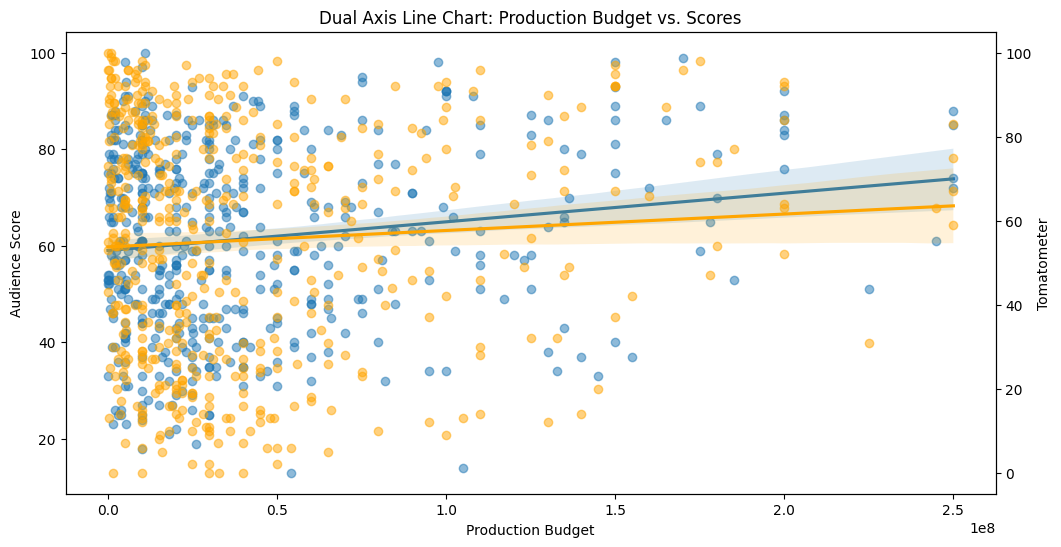

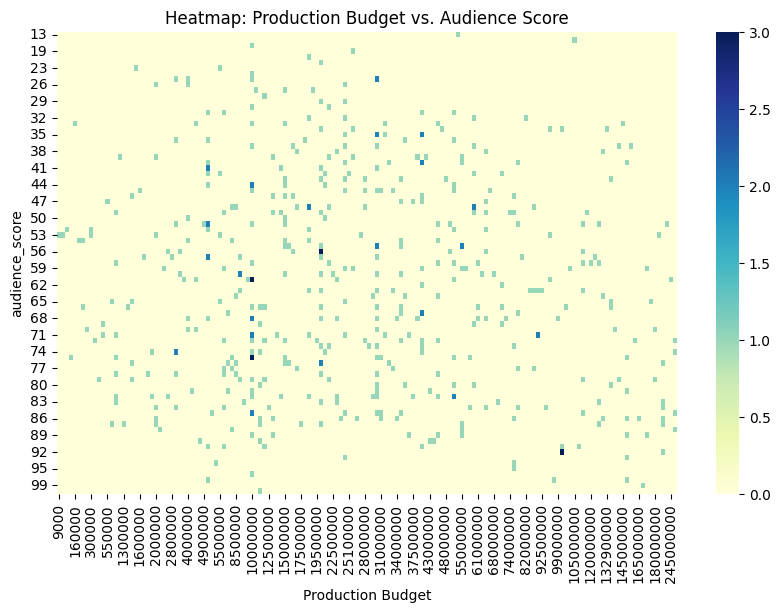

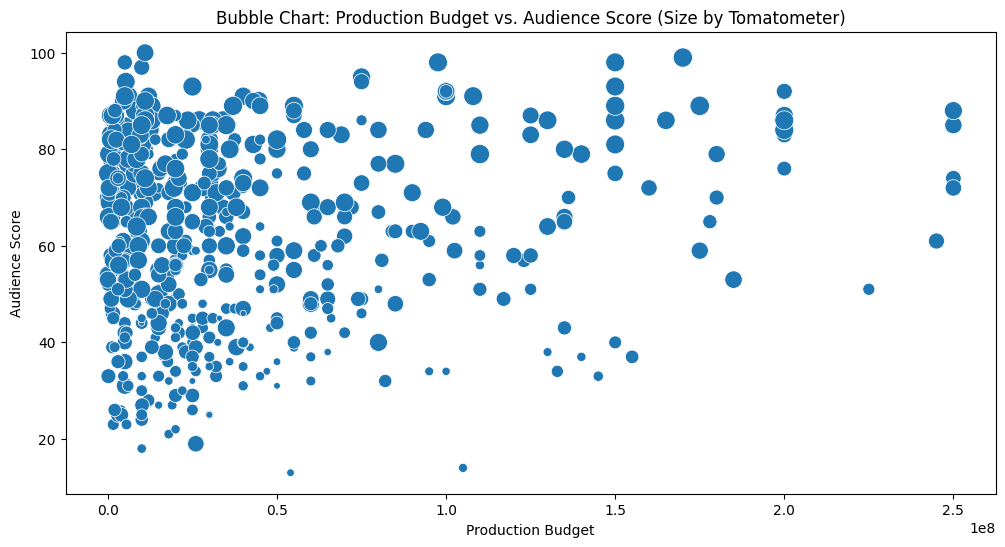

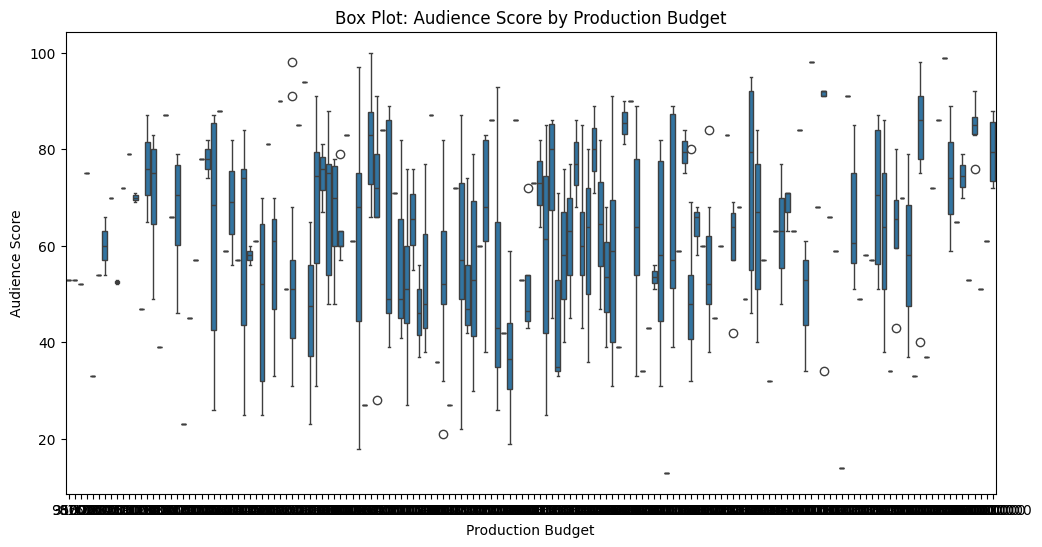

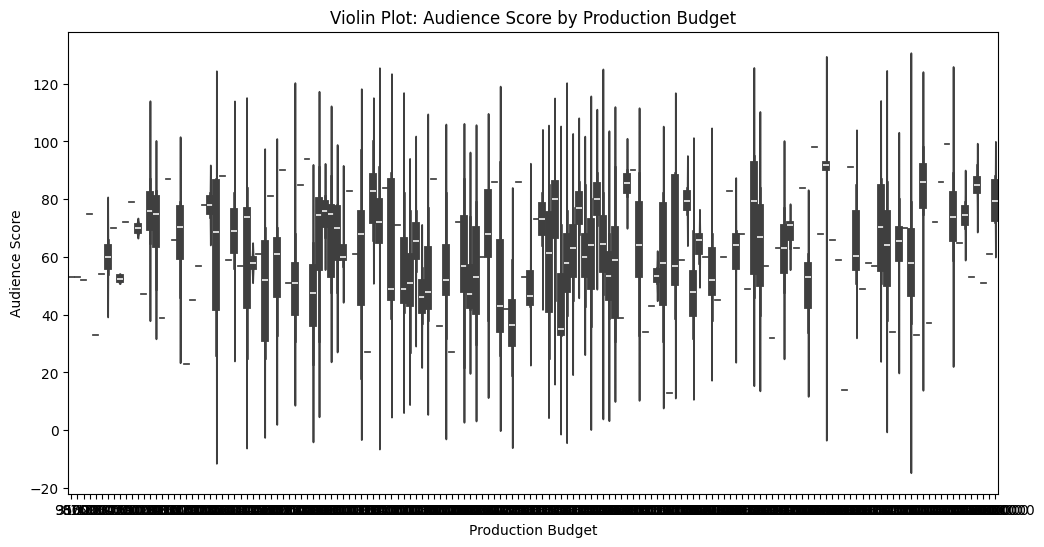

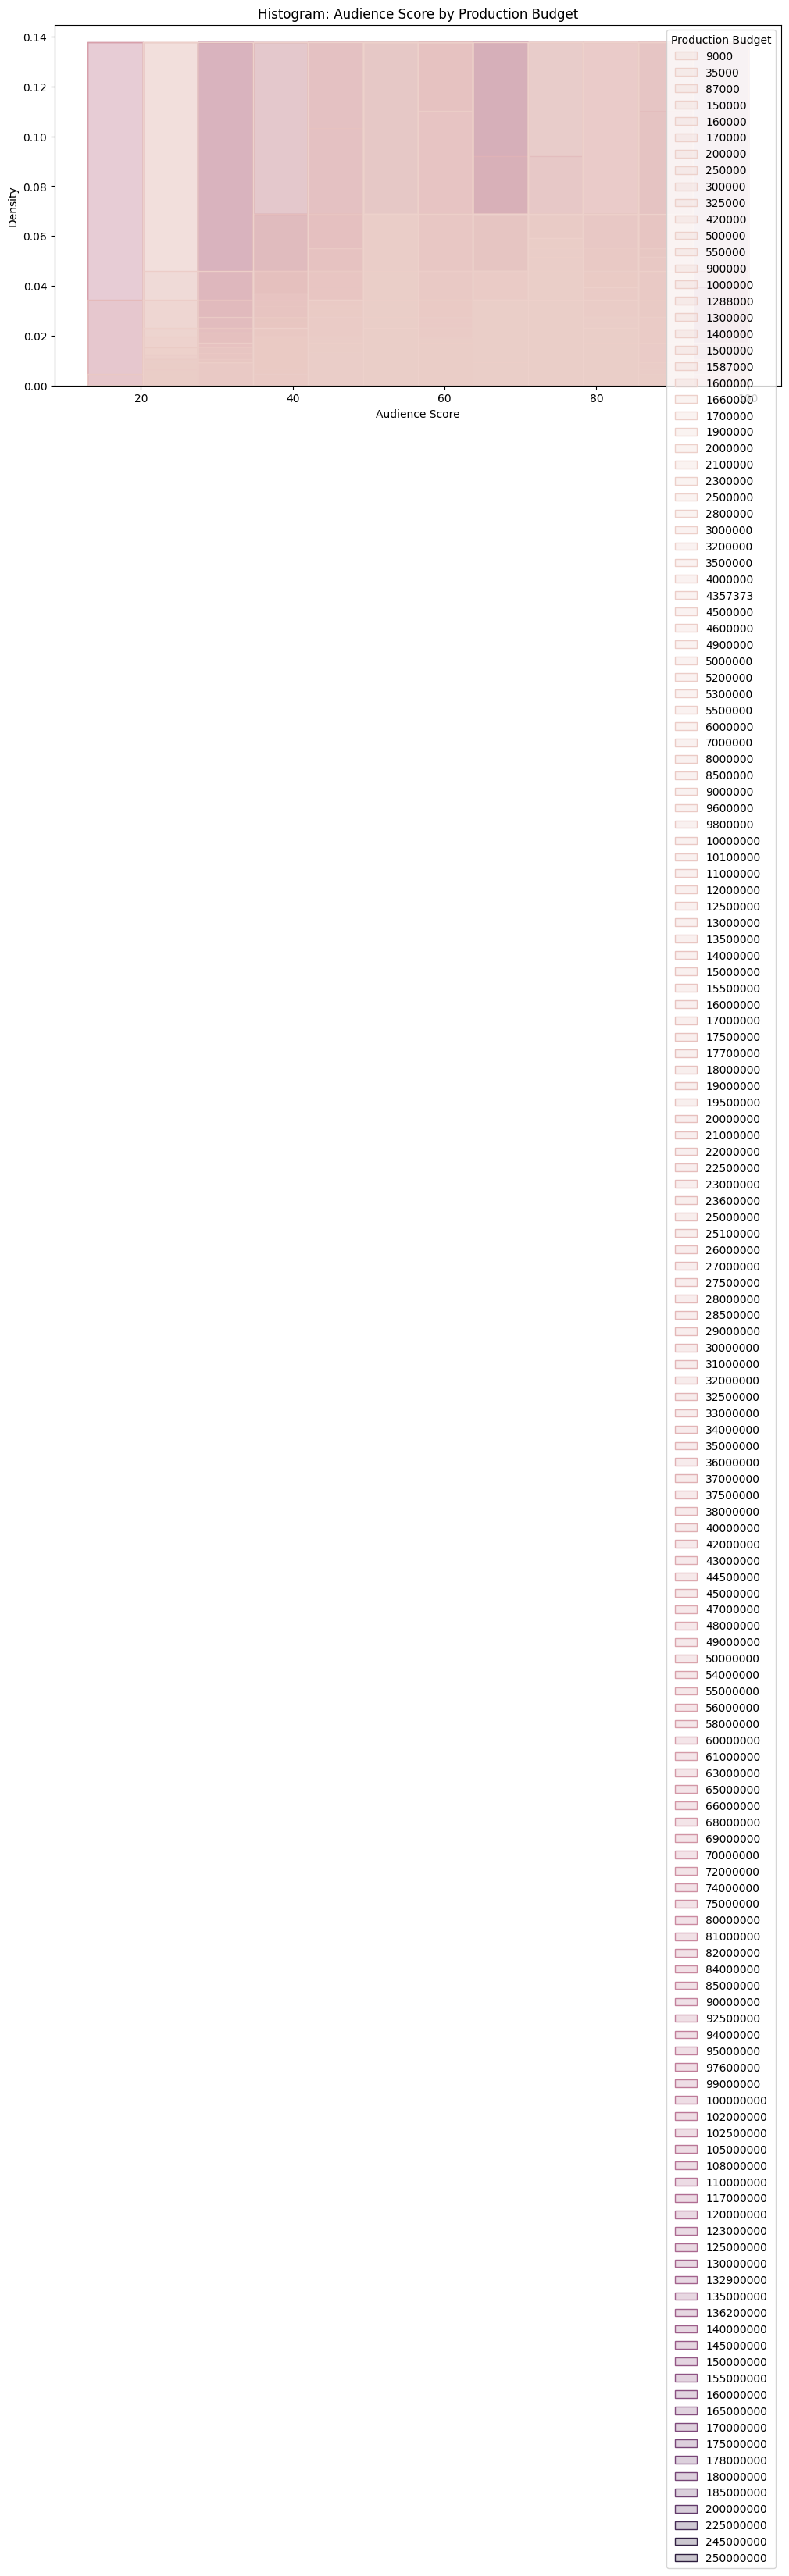

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns

# Creating a smaller sample for clearer visualizations
sample_data = data.sample(500, random_state=1)

# Dual Axis Line Chart
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
sns.regplot(x='Production Budget', y='audience_score', data=sample_data, ax=ax1, label='Audience Score', scatter_kws={'alpha':0.5})
sns.regplot(x='Production Budget', y='tomatometer', data=sample_data, ax=ax2, label='Tomatometer', color='orange', scatter_kws={'alpha':0.5})
ax1.set_xlabel('Production Budget')
ax1.set_ylabel('Audience Score')
ax2.set_ylabel('Tomatometer')
plt.title('Dual Axis Line Chart: Production Budget vs. Scores')
plt.show()

# Heatmap for Production Budget vs. Audience Score
plt.figure(figsize=(10, 6))
heatmap_data = sample_data.pivot_table(index='audience_score', columns='Production Budget', aggfunc='size', fill_value=0)
sns.heatmap(heatmap_data, cmap="YlGnBu")
plt.title('Heatmap: Production Budget vs. Audience Score')
plt.show()

# Bubble Chart
plt.figure(figsize=(12, 6))
sns.scatterplot(data=sample_data, x='Production Budget', y='audience_score', size='tomatometer', legend=False, sizes=(20, 200))
plt.title('Bubble Chart: Production Budget vs. Audience Score (Size by Tomatometer)')
plt.xlabel('Production Budget')
plt.ylabel('Audience Score')
plt.show()

# Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Production Budget', y='audience_score', data=sample_data)
plt.title('Box Plot: Audience Score by Production Budget')
plt.xlabel('Production Budget')
plt.ylabel('Audience Score')
plt.show()

# Violin Plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='Production Budget', y='audience_score', data=sample_data)
plt.title('Violin Plot: Audience Score by Production Budget')
plt.xlabel('Production Budget')
plt.ylabel('Audience Score')
plt.show()

# Histogram/Density Plot
plt.figure(figsize=(12, 6))
sns.histplot(sample_data, x='audience_score', hue='Production Budget', element="step", stat="density", common_norm=False)
plt.title('Histogram: Audience Score by Production Budget')
plt.xlabel('Audience Score')
plt.ylabel('Density')
plt.show()


In [151]:
X_profit = data[['diversity_score_shannon_diversity_index', 'diversity_score_gini_simpson_index', 'Production Budget', 'year']]
X_profit = sm.add_constant(X_profit)  # Adding a constant for intercept

# Dependent variable: Profitability
y_profit = data['profitability']
model_profit = sm.OLS(y_profit, X_profit).fit()

# Displaying the regression summary
print("Regression Summary for Profitability:")
print(model_profit.summary())

Regression Summary for Profitability:
                            OLS Regression Results                            
Dep. Variable:          profitability   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     5.655
Date:                Sat, 09 Dec 2023   Prob (F-statistic):           0.000158
Time:                        13:01:26   Log-Likelihood:                -18779.
No. Observations:                2322   AIC:                         3.757e+04
Df Residuals:                    2317   BIC:                         3.760e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

In [ ]:
# To create a stacked bar chart, we need to restructure the data so that each genre's proportion is a separate column
# We'll use the previously identified top_genres list and add an 'Others' category

# Initialize a dictionary to hold the counts for each genre
genre_counts_dict = {genre: 0 for genre in top_genres}
genre_counts_dict['Others'] = 0

# Count the occurrences for each genre
for genres_list in data['genres']:
    # Increment the count for each genre in the genres_list
    for genre in genres_list:
        if genre in genre_counts_dict:
            genre_counts_dict[genre] += 1
        else:
            genre_counts_dict['Others'] += 1

# Calculate the total number of movies
total_movies = sum(genre_counts_dict.values())

# Convert counts to proportions
for genre in genre_counts_dict:
    genre_counts_dict[genre] = genre_counts_dict[genre] / total_movies

# Creating the DataFrame for the stacked bar chart
stacked_data = pd.DataFrame(list(genre_counts_dict.items()), columns=['Genre', 'Proportion'])

# Create a single-row DataFrame to plot a stacked bar chart
stacked_data_transposed = pd.DataFrame(stacked_data['Proportion']).T
stacked_data_transposed.columns = stacked_data['Genre']

# Plotting the stacked bar chart
stacked_data_transposed.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Stacked Bar Chart of Movie Genre Proportions')
plt.ylabel('Proportion')
plt.xticks([])
plt.legend(title='Genres')
plt.show()


In [170]:
import pandas as pd
import statsmodels.api as sm

# Load the dataset
data = pd.read_csv('data_with_diversity.csv')

# Define your top genres list here (add or remove genres as needed)
top_genres = ['Drama', 'Comedy', 'Mystery & Thriller', 'Action', 'Adventure', 
              'Fantasy', 'Romance', 'Horror', 'Kids & Family', 'Sci-Fi']  # Add more genres as needed

# Function to perform regression analysis
def perform_regression_gini_simpson(genre, data, dependent_var):
    genre_data = data[data['genres'].apply(lambda x: genre in x)]
    yearly_data = genre_data.groupby('year').agg({
        dependent_var: 'mean',
        'diversity_score_gini_simpson_index': 'mean',
        'Production Budget': 'mean'
    }).dropna()

    yearly_data.reset_index(inplace=True)
    yearly_data['year'] = yearly_data['year'].astype(int)

    X = yearly_data[['diversity_score_gini_simpson_index', 'Production Budget', 'year']]
    y = yearly_data[dependent_var]
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()
    return model

# Performing regression for each genre and model
models = ["Audience Score", "TomatoMeter", "Profitability"]
results = {model: {} for model in models}

for model in models:
    dependent_var = 'audience_score' if model == "Audience Score" else 'tomatometer' if model == "TomatoMeter" else 'profitability'
    for genre in top_genres:
        results[model][genre] = perform_regression_gini_simpson(genre, data, dependent_var)

# Exporting results to CSV
for model, genres in results.items():
    model_results = []
    for genre, result in genres.items():
        summary = {
            'Genre': genre,
            'R-Squared': result.rsquared,
            'Diversity Index Coefficient': result.params['diversity_score_gini_simpson_index'],
            'Budget Coefficient': result.params['Production Budget'],
            'Year Coefficient': result.params['year']
        }
        model_results.append(summary)
    
    results_df = pd.DataFrame(model_results)
    results_df.to_csv(f'{model}_Regression_Results_Gini_Simpson.csv', index=False)

print("Regression results exported as CSV files.")


Regression results exported as CSV files.


In [179]:
import pandas as pd
import statsmodels.api as sm

# Load the dataset
data = pd.read_csv('data_with_diversity.csv')

# Define your top genres list here (add or remove genres as needed)
top_10_genres = ['Drama', 'Comedy', 'Mystery & Thriller', 'Action', 'Adventure', 
              'Fantasy', 'Romance', 'Horror', 'Kids & Family', 'Sci-Fi']  # Add more genres as needed

# Function to perform multiple linear regression for Audience Score vs Diversity Index, Year, and Budget for a given genre
def perform_multiple_regression(genre, data):
    # Filter data for the specific genre
    genre_data = data[data['genres'].apply(lambda x: genre in x)]

    # Group by year and calculate mean values for the variables
    yearly_data = genre_data.groupby('year').agg({
        'tomatometer': 'mean',
        'diversity_score_gini_simpson_index': 'mean',
        'Production Budget': 'mean'
    }).dropna()

    # Adding Year as a numerical variable for regression
    yearly_data.reset_index(inplace=True)
    yearly_data['year'] = yearly_data['year'].astype(int)
    
    # Define the independent variables (X) and the dependent variable (y)
    X = yearly_data[['diversity_score_gini_simpson_index', 'Production Budget', 'year']]
    y = yearly_data['tomatometer']

    # Adding a constant for regression
    X = sm.add_constant(X)
    
    # Fit the regression model
    model = sm.OLS(y, X).fit()
    
    return model

# Perform multiple regression for each of the top 10 genres and store the summary
multiple_regression_models = {genre: perform_multiple_regression(genre, data) for genre in top_10_genres}

# Extract the summary statistics for each model
multiple_regression_summaries = {genre: model.summary() for genre, model in multiple_regression_models.items()}

# For conciseness, let's display the R-squared values for each genre's model as an example
r_squared_values = {genre: model.rsquared for genre, model in multiple_regression_models.items()}
r_squared_values

# Since the summaries are extensive, we'll create a function to extract the key details from each model's summary
def extract_model_details(model):
    # Extracting the parameters, p-values, and the R-squared value from the regression model
    params = model.params
    pvalues = model.pvalues
    rsquared = model.rsquared
    
    # Creating a summary dictionary
    summary = {
        'Coefficients': params,
        'P-Values': pvalues,
        'R-Squared': rsquared
    }
    
    return summary

# Extracting the details for each genre's model
multiple_regression_details = {genre: extract_model_details(model) for genre, model in multiple_regression_models.items()}

# Displaying the details for one genre as an example
multiple_regression_details['Comedy']  # Replace 'Comedy' with any other genre to see its details

# Extract the coefficients and p-values for all genres and create a DataFrame for easy viewing
regression_results = []

for genre, details in multiple_regression_details.items():
    genre_results = {
        'Genre': genre,
        'Diversity Index Coefficient': details['Coefficients']['diversity_score_gini_simpson_index'],
        'Diversity Index P-Value': details['P-Values']['diversity_score_gini_simpson_index'],
        'Budget Coefficient': details['Coefficients']['Production Budget'],
        'Budget P-Value': details['P-Values']['Production Budget'],
        'Year Coefficient': details['Coefficients']['year'],
        'Year P-Value': details['P-Values']['year'],
        'R-Squared': details['R-Squared']
    }
    regression_results.append(genre_results)

regression_results_df = pd.DataFrame(regression_results)
regression_results_df

# Exporting the results to a CSV file
regression_results_df.to_csv('Multiple_Regression_Results.csv', index=False)